In [1]:
#This is a convolutional AutoEncoder

In [195]:
import os

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mplimg

import PIL
from PIL import Image

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, LSTM, Flatten, Reshape
from keras.models import Model
from keras import backend as K

In [82]:
#Constant Settings
datapath = 'VideoData/Video0/frames'
image_names = [_ for _ in os.listdir(datapath) if '.j' in _ or '.p' in _]

currentVideo = 0
imageDim = 252

trainTestSplit = 0.7 #Ratio of input domain belonging to train

In [83]:
#Image Getters
def getVideoFrame(v, x):
    datapath, filename = 'VideoData/Video{}/frames'.format(v), 'frame{:05}.png'.format(x)
    return os.path.join(datapath, filename)

def getImagePath(x):
    return os.path.join(datapath, image_names[x])

<class 'PIL.PngImagePlugin.PngImageFile'>


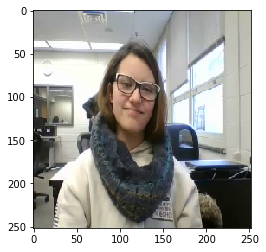

In [164]:
#Test for image getter
testimg = Image.open(getVideoFrame(0, 70))
print(type(testimg))
testimg = testimg.resize((imageDim, imageDim))
plt.imshow(testimg)

In [125]:
images = 152
allData = np.array([np.array(Image.open(getVideoFrame(currentVideo, _+1)).resize((imageDim, imageDim)))/255 for _ in range(images)])

In [127]:
ratioSplit = int(allData.shape[0] * trainTestSplit)

x_train, x_test = allData[:ratioSplit], allData[ratioSplit:]

In [180]:
#Big AutoEncoder
input_img = Input(shape=(imageDim, imageDim, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
# (32, 32, 8) = 8192

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [148]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=1,
                shuffle=True,
                validation_data=(x_test, x_test))

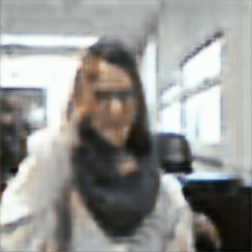

In [171]:
testoutput = autoencoder.predict(allData[30:31]) * 255
Image.fromarray(testoutput[0].astype('uint8'), 'RGB')

In [215]:
#Classifier
encoderCoreShape = 32*32*8
look_back = 3
classifierX = Reshape((32*32,8))(encoded)
classifierX = LSTM(8, input_shape=(encoderCoreShape, look_back), return_sequences=False)(classifierX)
classifierX = Dense(16, activation='relu')(classifierX)
classifierX = Dense(2, activation='softmax')(classifierX)

In [253]:
#hello
hello = allData[15:60]
name = allData[90:106]
x_train_LSTM = np.concatenate((hello, name), axis = 0)
y_train_LSTM = np.concatenate((np.array([[1, 0] for i in range(hello.shape[0])]), np.array([[0, 1] for i in range(name.shape[0])])), axis = 0)

In [254]:
simpleClassifier = Model(input_img, classifierX)
simpleClassifier.compile(optimizer='adadelta', loss='binary_crossentropy')

In [256]:
simpleClassifier.fit(x_train_LSTM, y_train_LSTM,
                epochs=2,
                batch_size=10,
                shuffle=False
                    )#validation_data=(x_test, x_test))

Epoch 1/2
61/61 [==============================] - 37s 602ms/step - loss: 0.6078
Epoch 2/2
61/61 [==============================] - 9s 144ms/step - loss: 0.6687


In [258]:
simpleClassifier.predict(allData[88:110])

array([[0.50524974, 0.49475023],
       [0.5035639 , 0.4964361 ],
       [0.5065396 , 0.4934604 ],
       [0.5022629 , 0.4977371 ],
       [0.50297034, 0.49702966],
       [0.5027258 , 0.49727422],
       [0.5025462 , 0.49745375],
       [0.50219744, 0.49780256],
       [0.5022017 , 0.49779832],
       [0.5022045 , 0.4977955 ],
       [0.5021665 , 0.49783355],
       [0.5021978 , 0.49780223],
       [0.5022104 , 0.49778956],
       [0.502227  , 0.497773  ],
       [0.50289685, 0.49710315],
       [0.5035129 , 0.4964871 ],
       [0.50428003, 0.4957199 ],
       [0.5064517 , 0.4935483 ],
       [0.5085748 , 0.49142522],
       [0.5124103 , 0.48758978],
       [0.5126607 , 0.4873393 ],
       [0.51157   , 0.48842996]], dtype=float32)